In [1]:
import sys 
sys.path.append('/home/lumargot/trachoma/src/py')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # put -1 to not use any
from torch import Tensor, nn

In [2]:
from loaders.tt_dataset import BBXImageTestTransform, BBXImageEvalTransform, TTDataModuleBX
import SimpleITK as sitk
import torch
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from torch import Tensor, nn
import torchvision

import tensorflow as tf
import numpy as np
import pandas as pd 
from visualization import *
from evaluation import *
from utils import *


2025-07-13 09:25:40.001677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752413140.014829  268515 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752413140.018944  268515 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752413140.030201  268515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752413140.030212  268515 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752413140.030214  268515 computation_placer.cc:177] computation placer alr

In [3]:
from nets.segmentation import TTRoidHead, FasterTTRCNN, TTRPN
from collections import OrderedDict
from torchvision.ops import nms

In [4]:
ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold2/epoch=19-val_loss=1.85.ckpt' #best!
model = FasterTTRCNN(out_features=4, class_weights = torch.ones(4))
state_dict = torch.load(ckpt, weights_only=False, map_location='cpu') # or 'cuda' if loading to GPU
model.load_state_dict(state_dict['state_dict'])
model.eval()


rpn = TTRPN(model.model)
rpn.eval

roi_head = TTRoidHead(model.model)
roi_head.eval()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TTRoidHead(
  (faster): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(512,), max_size=1024, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, mome

In [5]:
## load RPN
itp_rpn = tf.lite.Interpreter(model_path="faster-rcnn-cpu/rpn_p1/rpn_p1_float32.tflite",  
                              experimental_delegates=[])

itp_roi = tf.lite.Interpreter(model_path="faster-rcnn-cpu/roi_p2/roi_p2_float32.tflite", 
                              experimental_delegates=[],)


    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
INFO: Created TensorFlow Lite delegate for select TF ops.
I0000 00:00:1752413151.029754  268515 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46709 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:43:00.0, compute capability: 8.6
INFO: TfLiteFlexDelegate delegate: 4 nodes delegated out of 516 nodes with 1 partitions.



In [6]:

# === old === #
mount_point = "/CMF/data/lumargot/trachoma/"

df_train = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold0_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold0_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold0_test.csv')

df_test = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_test.csv')
df_test = df_test.drop_duplicates(subset=['x_patch', 'y_patch', 'filename'])

concat_labels=['overcorrection', 'ECA', 'Gap', 'Fleshy']
drop_labels = ['Short Incision', 'Reject']

img_column= "filename" 
class_column = 'class'
label_column = 'label'

map ={ 1:'Healthy', 2:'Entropion', 3:'Overcorrection'}


In [7]:
df_test = remove_labels(df_test, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)
df_train = remove_labels(df_train, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)
df_val = remove_labels(df_val, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)

df_test = df_test.loc[df_test['dataset'] == 'PoPP_Data']

In [8]:
ttdata = TTDataModuleBX(df_train, df_val, df_test, batch_size=1, num_workers=1, img_column='filename',severity_column='sev', 
                        mount_point=mount_point, class_column= class_column,
                        train_transform=BBXImageEvalTransform(), 
                        valid_transform=BBXImageEvalTransform(), 
                        test_transform=BBXImageTestTransform(height=666, width=1333))
ttdata.setup()
dataload = ttdata.test_dataloader()
ds = ttdata.test_ds

In [9]:
proposals = rpn(ds[0]['img'].unsqueeze(0))
out = roi_head(ds[0]['img'].unsqueeze(0), proposals)

In [16]:
def x_iou(boxA, boxB):
    """Compute IoU only along the x-axis."""
    x1_A, y1_A, x2_A, y2_A = boxA
    x1_B, y1_B, x2_B, y2_B = boxB
    
    if (y2_A >= y1_B or y2_B >= y1_A):
        
        inter = max(0, min(x2_A, x2_B) - max(x1_A, x1_B))
        union = (x2_A - x1_A) + (x2_B - x1_B) - inter
        return inter / union if union > 0 else 0
    return 0

def y_overlap(boxA, boxB):
    """Check if boxes overlap in the y-axis."""
    return not (boxA[3] <= boxB[1] or boxB[3] <= boxA[1])
    
def custom_x_nms(preds, iou_thresh=0.8):
    """ Apply NMS based only on x-axis IoU. """
    boxes = preds['boxes']
    if 'scores' in preds.keys():
        scores = preds['scores']
    else:
        scores = torch.ones_like(preds['labels'])

    idxs = np.argsort(-scores)  # sort descending by score
    keep = []

    while len(idxs) > 0:
        current = idxs[0]
        keep.append(current)
        rest = idxs[1:]
        
        ious = np.array([x_iou(boxes[current], boxes[i]) for i in rest])
        idxs = rest[ious <= iou_thresh]

    return torch.stack(keep)


def process_predictions(preds):
  original_preds = {}
  for k in preds.keys():
    original_preds[k] = preds[k].cpu().detach().numpy()

  keep = preds['scores'] > 0.1
  preds = filter_targets_indices(preds, keep, detach=True)

  pred_indices = custom_x_nms(preds, iou_thresh=0.4)
  preds = filter_targets_indices(preds, pred_indices, detach=True)
  preds = fill_empty_patches(preds)
  preds = replace_sandwiched_labels(preds)
  return preds, original_preds


colormap = {
  'Reject':(0,0,0),
  'Healthy':(0, 104, 0),
  'Entropion':(0, 0, 153),
  'Overcorrection':(0, 150, 150),
  'Overlapping_area':(128,128, 128),
}

def plot_patches(img, targets, map, title='ground truth'):
  ax = plt.gca()
  ax.imshow(img)
  ax.set_title(title)

  boxes = targets['boxes']
  labels = targets['labels']

  for j in range(labels.shape[0]):
    box = boxes[j]
    label = labels[j]

    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    color = np.array(colormap[map[label.item()]])/255

    rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=1.5)
    ax.add_patch(rect)

    # if 'scores' in targets.keys():
    #   score = targets['scores'][j].cpu().detach().numpy()
    #   ax.text(x1, y1-100, f'{score:.2f}', color='red')

In [17]:
def eye_level_outcome(preds,img_shape):
  unique_labels, counts = np.unique(preds['labels'], return_counts=True)
  unique_labels = unique_labels[counts >=3]
  counts = counts[counts>=3]

  outcome = -1 

  if len(unique_labels) == 3:
    labels, ct = unique_labels[1:], counts[1:]
    max_labels = labels[ np.argwhere(ct == np.amax(ct))][:,0]
    if np.std(ct) >=1:
      outcome = max_labels.item()
    else:
      outcome = -1

  elif len(unique_labels) == 2:
    if 1 in unique_labels:
      outcome = max(unique_labels)
    else: 
      if np.std(counts) >=1:
        max_labels = unique_labels[ np.argwhere(counts == np.amax(counts))][:,0]
        outcome = max(max_labels).item()
      else:
        outcome = -1
  elif len(unique_labels) == 1:
      outcome = unique_labels.item()
  else:
    outcome =-1
  
  return outcome 

In [14]:
from tqdm import tqdm
import json

In [41]:
num_preds,num_fps,num_fns = 0, 0, 0
l_ious, l_distances = [], []
l_distances = []
gt, pred = [], []
data_out = {}
lcid,leye = [], []
datasets = []
gt_eye, pred_eye = [], []
probs= []
for idx, batch in enumerate(tqdm(dataload)):
  
  targets = batch
  imgs = targets.pop('img', None)
  # outs = model(imgs, mode='test')
  # out_img = outs[0]
  # out_img = { 'boxes':out_img['boxes'].cpu().detach(), 'labels':out_img['labels'].cpu().detach(), 'scores':out_img['scores'].cpu().detach()}

  # itp_rpn.allocate_tensors()
  # input_details = itp_rpn.get_input_details()
  # output_details = itp_rpn.get_output_details()

  # itp_rpn.set_tensor(input_details[0]['index'], imgs.permute(0,2,3,1))
  # itp_rpn.invoke()

  # prpl_tf = itp_rpn.get_tensor(output_details[0]['index'])

  # itp_roi.allocate_tensors()

  # input_details = itp_roi.get_input_details()
  # output_details = itp_roi.get_output_details()

  # itp_roi.set_tensor(input_details[0]['index'], imgs.permute(0,2,3,1))
  # itp_roi.set_tensor(input_details[1]['index'], prpl_tf)
  # itp_roi.invoke()

  # boxes_tf = itp_roi.get_tensor(output_details[0]['index'])
  # labels_tf = itp_roi.get_tensor(output_details[1]['index'])
  # scores_tf = itp_roi.get_tensor(output_details[2]['index'])

  proposals = rpn(imgs)
  out = roi_head(imgs, proposals)
  out_dict = [{'boxes':torch.tensor(out[0]), 'labels':torch.tensor(out[1]),  'scores':torch.tensor(out[2])}]

  # out_dict = [{'boxes':torch.tensor(boxes_tf)[:, [0,2,1,3]], 'labels':torch.tensor(labels_tf),  'scores':torch.tensor(scores_tf)}]
  out_dict = roi_head.faster.transform.postprocess(out_dict, roi_head.images_shapes, roi_head.og_sizes)
  out_img = out_dict[0]



  # remove overlapping boxes with iou > 0.7  
  ### -- gt -- ###
  gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=1.0) ## iou as args
  filename = ds.data.df_subject.iloc[idx]['filename']
  targets['boxes'] = targets['boxes'][0,gt_indices].cpu().detach()
  targets['labels'] = targets['labels'][0,gt_indices].cpu().detach()  


  gt_eye.append(gt_eye_outcome(targets['labels']))

  ### -- preds -- ###
  eyelid_seg = select_eyelid_seg(targets['mask'][0])
  preds = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.5)
  preds = process_predictions(preds)

  pred_eye.append(eye_level_outcome(preds, imgs.shape[2:]))


  ## box-level evaluation
  n_p, n_fp, n_fn, i, d, gt_ix, pred_idx = evaluate_with_fp_fn(targets['boxes'], preds['boxes'])

  gt.append(targets['labels'][gt_ix])
  pred.append(preds['labels'][pred_idx])
  probs.append(preds['scores'][pred_idx])

  num_preds += n_p
  num_fps += n_fp
  num_fns += n_fn
  l_ious.append(torch.tensor(i).reshape(-1))
  l_distances.append(torch.tensor(d))


100%|██████████| 188/188 [03:45<00:00,  1.20s/it]


In [42]:
ious = torch.cat(l_ious, dim=0)
dist = torch.cat(l_distances, dim=0)
pred = np.concatenate(pred)
gt = np.concatenate(gt)
# probs = np.concatenate(probs)

total_detections = num_preds + num_fns + num_fps
out_dict = {'Matched Prediction': num_preds,
            'Ratio match prediction': 100*num_preds/total_detections, 
            'False Positives':num_fps,
            'Ratio FP': 100*num_fps/total_detections, 
            'False Negatives':num_fns,
            'Ration FN': 100*num_fns/total_detections, 
            'Mean IoU': ious.mean().item(),
            }
print(json.dumps(out_dict, indent=2))


{
  "Matched Prediction": 2463,
  "Ratio match prediction": 79.32367149758454,
  "False Positives": 429,
  "Ratio FP": 13.816425120772946,
  "False Negatives": 213,
  "Ration FN": 6.859903381642512,
  "Mean IoU": 0.5632542962432081
}


In [48]:

from sklearn.metrics import classification_report, confusion_matrix

from visualization import *
from evaluation import *


              precision    recall  f1-score   support

           1       0.88      0.75      0.81      1914
           2       0.34      0.67      0.45       165
           3       0.47      0.64      0.54       384

    accuracy                           0.73      2463
   macro avg       0.57      0.69      0.60      2463
weighted avg       0.78      0.73      0.74      2463

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.6854384360849878


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


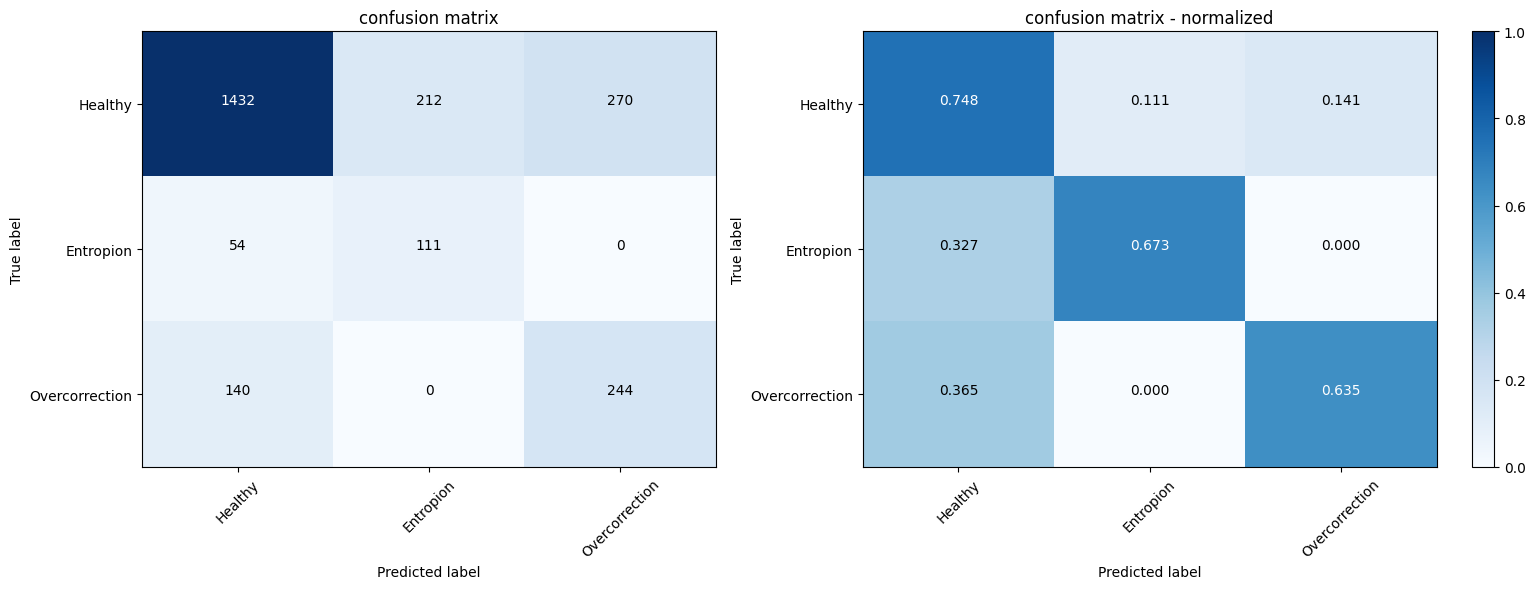

In [58]:
df_pret = pd.DataFrame(data={'gt':gt, 'pred':pred})
name = os.path.splitext(ckpt)[0]
df_pret.to_csv(name + '_box-level_prediction.csv')

print(classification_report(df_pret['gt'], df_pret['pred']))
report = classification_report(df_pret['gt'], df_pret['pred'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(name + '_box-level_report.csv')


class_names = ['Healthy', 'Entropion', 'Overcorrection']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_pret['gt'], df_pret['pred'])
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
plt.savefig(name + '_box-level_cm.png',dpi=200)